In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stocktrends import Renko

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
assets = ['BTC-USD' , 'ETH-USD', 'ADA-USD' , 'TRX-USD' , 'BNB-USD' , 'XRP-USD', 'LINK-USD' , 'LTC-USD']

In [5]:
data = pd.DataFrame()
for a in assets:
    data[a+' Open'] = yf.download(tickers = a , start= '2023-01-01' )['Open']
    data[a+' Close'] = yf.download(tickers = a , start= '2023-01-01')['Close']
    data[a+' High'] = yf.download(tickers = a , start= '2023-01-01')['High']
    data[a+' Low'] = yf.download(tickers = a , start= '2023-01-01')['Low']
    data[a+' Volume'] = yf.download(tickers = a , start= '2023-01-01')['Volume']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [13]:
def ATR(DF,i,n):
    df = DF.copy()
    df[i+'H-L']=abs(df[i+' High']- df[i+' Low'])
    df[i+'H-PC']=abs(df[i+' High']-df[i+' Close'].shift(1))
    df[i+'L-PC']=abs(df[i+' Low']-df[i+' Close'].shift(1))
    df[i+'TR']=df[[i+'H-L', i+'H-PC', i+'L-PC']].max(axis=1,skipna=False)
    df[i+' ATR'] = df[i+'TR'].rolling(n).mean()
    df2 = df.drop([i+'H-L',i+'H-PC',i+'L-PC'],axis=1)
    return df2[i+' ATR']



def renko_DF(DF,a):
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.loc[:,['Date',a+' Open',a+' High',a+' Low',a+' Close',a+' Volume']]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,a,120)[-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df[a+" bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df[a+" bar_num"])):
        if renko_df[a+" bar_num"][i]>0 and renko_df[a+" bar_num"][i-1]>0:
            renko_df[a+" bar_num"][i]+=renko_df[a+" bar_num"][i-1]
        elif renko_df[a+" bar_num"][i]<0 and renko_df[a+" bar_num"][i-1]<0:
            renko_df[a+" bar_num"][i]+=renko_df[a+" bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df



def slope(ser,n):
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)



def MACD(DF,i,a,b,c):
    df = DF.copy()
    df["MA_Fast"]=df[i+" Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df[i+" Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return (df["MACD"],df["Signal"])


In [14]:
tickers_signal = {}
tickers_ret = {}
ohlc_renko = pd.DataFrame()
data1 = data.copy()


In [15]:
for a in assets:
    print("Working for ",a)
    renko = renko_DF(data1 , a)
    renko.columns = [a+" Date","open","high","low","close","uptrend","bar_num"]
    
    data1[a+" Date"] = data.index
    if a =='BTC-USD':
        ohlc_renko = data1.merge(renko.loc[:,[a+" Date","bar_num"]],how="outer",on= a+" Date")
    
    ohlc_renko[a+" bar_num"] = renko['bar_num']
    ohlc_renko[a+" bar_num"].fillna(method='ffill',inplace=True)
    data1[a+" macd"]= MACD(data1,a,12,26,9)[0]
    data1[a+" macd_sig"]= MACD(data1,a,12,26,9)[1]
    data1[a+" macd_slope"]= slope(data1[a+" macd"],5)
    data1[a+" macd_sig_slope"]= slope(data1[a+" macd_sig"],5)
    tickers_signal[a] = ""
    tickers_ret[a] = []

Working for  BTC-USD
Working for  ETH-USD
Working for  ADA-USD
Working for  TRX-USD
Working for  BNB-USD
Working for  XRP-USD
Working for  LINK-USD
Working for  LTC-USD


In [16]:
for a in assets:
    data1[a+' macd_sig_res'] = np.where(data1[a+" macd"]>data1[a+" macd_sig"] , 1 , 0)


In [17]:
for a in assets:
    print("calculating daily returns for ",a)
    tickers_ret[a] = []
    for i in range(len(ohlc_renko)):
        if tickers_signal[a] == "":
            tickers_ret[a].append(0)
            if i > 0:
                if ohlc_renko[a+" bar_num"][i]>=2 and data1[a+' macd_sig_res'][i]==1 and data1[a+" macd_slope"][i]>data1[a+" macd_sig_slope"][i]:
                    tickers_signal[a] = "Buy"
                elif ohlc_renko[a+" bar_num"][i]<=-2 and data1[a+' macd_sig_res'][i]==0 and data1[a+" macd_slope"][i]<data1[a+" macd_sig_slope"][i]:
                    tickers_signal[a] = "Sell"
        
        elif tickers_signal[a] == "Buy":
            tickers_ret[a].append((data1[a+" Close"][i]/data1[a+" Close"][i-1])-1)
            if i > 0:
                if ohlc_renko[a+" bar_num"][i]<=-2 and data1[a+' macd_sig_res'][i]==0 and data1[a+" macd_slope"][i]<data1[a+" macd_sig_slope"][i]:
                    tickers_signal[a] = "Sell"
                elif data1[a+" macd"][i]<data1[a+" macd_sig"][i] and data1[a+" macd_slope"][i]<data1[a+" macd_sig_slope"][i]:
                    tickers_signal[a] = ""
                
        elif tickers_signal[a] == "Sell":
            tickers_ret[a].append((data1[a+" Close"][i-1]/data1[a+" Close"][i])-1)
            if i > 0:
                if ohlc_renko[a+" bar_num"][i]>=2 and data1[a+' macd_sig_res'][i]==1 and data1[a+" macd_slope"][i]>data1[a+" macd_sig_slope"][i]:
                    tickers_signal[a] = "Buy"
                elif data1[a+" macd"][i]>data1[a+" macd_sig"][i] and data1[a+" macd_slope"][i]>data1[a+" macd_sig_slope"][i]:
                    tickers_signal[a] = ""
    ohlc_renko[a+" ret"] = np.array(tickers_ret[a])


calculating daily returns for  BTC-USD
calculating daily returns for  ETH-USD
calculating daily returns for  ADA-USD
calculating daily returns for  TRX-USD
calculating daily returns for  BNB-USD
calculating daily returns for  XRP-USD
calculating daily returns for  LINK-USD
calculating daily returns for  LTC-USD


In [18]:
for a in assets:
    print(" Strategy Signal for "+ a + " : " + tickers_signal[a])


 Strategy Signal for BTC-USD : Sell
 Strategy Signal for ETH-USD : Sell
 Strategy Signal for ADA-USD : 
 Strategy Signal for TRX-USD : 
 Strategy Signal for BNB-USD : 
 Strategy Signal for XRP-USD : 
 Strategy Signal for LINK-USD : 
 Strategy Signal for LTC-USD : 


<Axes: >

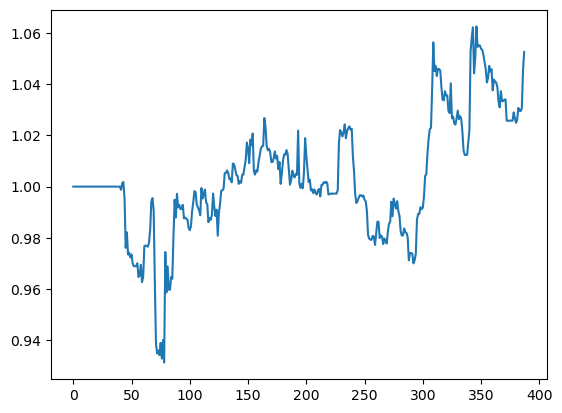

In [19]:
strategy_df = pd.DataFrame()
for a in assets:
    strategy_df[a] = ohlc_renko[a+" ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

(1+strategy_df["ret"]).cumprod().plot()
